In [1]:
# %%
rootdir = '/home/lscsc/caizhijie/shar-data/archive'

# %%
import glob
jpgs = glob.glob('%s/*/*/*.jpg' % rootdir)

import pandas as pd
import pickle as pk

df_jpgs = pd.DataFrame.from_dict({'jpg': jpgs})
df_jpgs['subdir'] = df_jpgs['jpg'].apply(lambda x: x.split('/')[-2])
df_jpgs['dir'] = df_jpgs['jpg'].apply(lambda x: x.split('/')[-3])
df_jpgs = df_jpgs[df_jpgs['subdir'].apply(lambda x: x[0] == 't')]

df_jpgs['mov'] = df_jpgs['dir'].apply(lambda x: x.split('_')[2])
df_jpgs['obj'] = df_jpgs['dir'].apply(lambda x: x.split('_')[3])
df_jpgs['ang'] = df_jpgs['dir'].apply(lambda x: x.split('_')[4])
df_jpgs['rep'] = df_jpgs['subdir'].apply(lambda x: x.split('_')[0].split('t')[-1])

In [2]:
import sys

openposepath = '/home/lscsc/caizhijie/ref-rep/pytorch-openpose'
sys.path.append(openposepath)
from src import util

import cv2
import torch
import numpy as np

class prep:
    def __init__(self):
        self.scale_search = [1.]
        self.boxsize = 368
        self.stride = 8
        self.padValue = 128
        self.thre1 = 0.1
        self.thre2 = 0.05
    
    def __call__(self, oriImg):
        self.multiplier = [x * self.boxsize / oriImg.shape[0] for x in self.scale_search]
        self.heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
        self.paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
        for m in range(len(self.multiplier)):
            scale = self.multiplier[m]
            imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
            imageToTest_padded, pad = util.padRightDownCorner(imageToTest, self.stride, self.padValue)
            im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
            im = np.ascontiguousarray(im)

            data = torch.from_numpy(im).float()

        return data

/home/lscsc/caizhijie/miniconda3/envs/mtmd/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch.utils.data import Dataset, DataLoader

preper = prep()

class _dataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, index):
        return self.df.iloc[index]
    
    def __len__(self):
        return len(self.df)
    
def collate_fn(batch):
    imgs = [preper(cv2.imread(_['jpg'])) for _ in batch]
    paths = [_['jpg'] for _ in batch]
    return np.stack(imgs), paths

inference_dataset = _dataset(df_jpgs)
inference_loader = DataLoader(inference_dataset, 64, shuffle=False, collate_fn=collate_fn)

In [4]:
from src import translator

gpuid = 1
device = 'cuda:%d' % gpuid

model_path = openposepath + '/model/body_pose_model.pth'
teacher = translator.bodypose_transparent()
model_dict = util.transfer(teacher, torch.load(model_path))
teacher.load_state_dict(model_dict)
teacher.to(device)
teacher.eval()
teacher.half()

bodypose_transparent(
  (model0): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_2): ReLU(inplace=True)
    (pool1_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_2): ReLU(inplace=True)
    (pool2_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel

single picture

In [5]:
import glob
import pandas as pd

darkdir = '/home/lscsc/caizhijie/0420-wamera-benchmark/darktest/'
jpglist = glob.glob(darkdir + 'p*.jpg')
df = pd.DataFrame.from_dict({'jpg': jpglist})

inference_dataset = _dataset(df)
inference_loader = DataLoader(inference_dataset, 2, shuffle=False, collate_fn=collate_fn)

In [6]:
import tqdm
kptlist = list()
afflist = list()
namelist = list()

batch1 = None

for i, batch in tqdm.tqdm(enumerate(inference_loader)):
    kpt, aff, _ = teacher(torch.tensor(batch[0]).squeeze().to(device).half())
    kptlist.extend(kpt.detach().cpu().numpy())
    afflist.extend(aff.detach().cpu().numpy())
    namelist.extend(batch[1])
    batch1 = batch

1it [00:00,  7.10it/s]


In [7]:
from previewer import previewbatch

img_batch, pcks = previewbatch(torch.tensor(batch1[0][:, 0, ...]), (kpt, aff), (kpt, aff), None, n=2)

In [8]:
img_batch[0].max()

255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


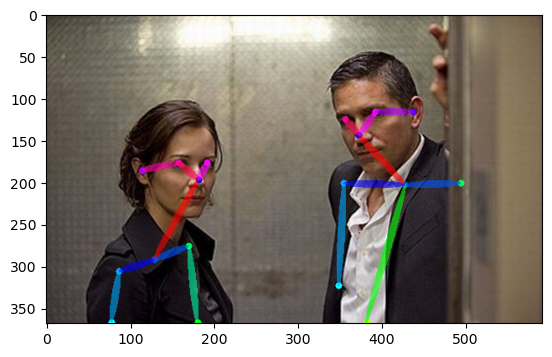

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img_batch[-1] / 255)

In [6]:
openpose_dstrootdir = '/home/lscsc/caizhijie/archive_0118/openpose/'
import os

for i in tqdm.trange(len(namelist)):
    try:
        pk.dump({'aff':afflist[i], 'kpt':kptlist[i]}, open(openpose_dstrootdir + ('/'.join(namelist[i].split('/')[-3:])[:-4] + '.pk'), 'wb'))
    except FileNotFoundError:
        if not os.path.exists(openpose_dstrootdir + '/'.join(namelist[i].split('/')[-3:-2])):
            os.mkdir(openpose_dstrootdir + '/'.join(namelist[i].split('/')[-3:-2]))
        if not os.path.exists(openpose_dstrootdir + '/'.join(namelist[i].split('/')[-3:-1])):
            os.mkdir(openpose_dstrootdir + '/'.join(namelist[i].split('/')[-3:-1]))

100%|██████████| 64000/64000 [01:15<00:00, 846.13it/s] 


: 